<a href="https://colab.research.google.com/github/akshaymathur777/AI-Project/blob/master/Copy_of_TCD_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.15

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [0]:
print(tf.__version__)

1.15.0


In [2]:
import glob
import pickle
import numpy
from music21 import converter, instrument, note, chord
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM 
from keras.layers import Bidirectional 
from keras.layers import GRU
from keras.layers import Activation
from keras.layers import BatchNormalization as BatchNorm
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os

Using TensorFlow backend.


In [0]:
import keras
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [0]:
def get_notes():
    """ Get all the notes and chords from the midi files in the ./midi_songs directory """
    notes = []
    for file in glob.glob("/content/drive/My Drive/AIAssignment/midi_songs/*.mid"):
        midi = converter.parse(file)

        print("Parsing %s" % file)

        notes_to_parse = None

        try: # file has instrument parts
            s2 = instrument.partitionByInstrument(midi)
            notes_to_parse = s2.parts[0].recurse() 
        except: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes

        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))

    with open('/content/drive/My Drive/AIAssignment/data/notes/notes.pkl', 'wb') as filepath:
        pickle.dump(notes, filepath)

    return notes

# New Section

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
notes = get_notes()

In [0]:
notes[1]

'7.8.0'

In [0]:
def prepare_sequences(notes, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    sequence_length = 100

    # get all pitch names
    pitchnames = sorted(set(item for item in notes))

     # create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM layers
    network_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalize input
    network_input = network_input / float(n_vocab)

    network_output = np_utils.to_categorical(network_output, dtype='float64')
    return (network_input, network_output)

In [0]:
def create_network_BiLSTM(network_input, n_vocab):
    """ create the structure of the neural network """
    model = Sequential()
    model.add(Bidirectional (LSTM(
        512,
        input_shape=(network_input.shape[1], network_input.shape[2]),
        recurrent_dropout=0.3,
        return_sequences=True
    )))
    model.add(Bidirectional(LSTM(512, return_sequences=True,recurrent_dropout=0.3)))
    model.add(LSTM(512))
    model.add(BatchNorm())
    model.add(Dropout(0.3))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNorm())
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    #model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

    return model

In [0]:
def create_network_GRU(network_input, n_vocab):
    """ create the structure of the neural network """
    model = Sequential()
    model.add(GRU(
        512,
        input_shape=(network_input.shape[1], network_input.shape[2]),
        recurrent_dropout=0.3,
        return_sequences=True
    ))
    model.add(GRU(512, return_sequences=True,recurrent_dropout=0.3))
    model.add(GRU(512))
    model.add(BatchNorm())
    model.add(Dropout(0.3))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNorm())
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

    return model

In [0]:

def create_network_LSTM(network_input, n_vocab):
    """ create the structure of the neural network """
    model = Sequential()
    model.add(LSTM(
        512,
        input_shape=(network_input.shape[1], network_input.shape[2]),
        recurrent_dropout=0.3,
        return_sequences=True
    ))
    model.add(LSTM(512, return_sequences=True,recurrent_dropout=0.3))
    model.add(LSTM(512))
    model.add(BatchNorm())
    model.add(Dropout(0.3))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNorm())
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    #model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    return model

In [0]:
from tensorflow.keras import backend as K
def train_network():
    """ Train a Neural Network to generate music """

    # get amount of pitch names
    n_vocab = len(set(notes))

    network_input, network_output = prepare_sequences(notes, n_vocab)
    X_train, X_test, y_train, y_test = train_test_split(network_input,network_output, test_size=0.10)
    # resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    # tf.config.experimental_connect_to_host(resolver.master())
    # tf.tpu.experimental.initialize_tpu_system(resolver)
    # #tf.initialize_all_variables().run()
    # strategy = tf.distribute.experimental.TPUStrategy(resolver)

    model = create_network_BiLSTM(X_train,n_vocab)
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    #model = create_network_LSTM(network_input, n_vocab)
    #model = create_network_BiLSTM(network_input, n_vocab)
    #model = create_network_GRU(network_input, n_vocab)
    X_train = X_train.astype(numpy.float32, copy=False)
    y_train = y_train.astype(numpy.float32, copy=False)
    train(model, X_train, y_train)
    return X_train, X_test, y_train, y_test

In [0]:
def train(model, network_input, network_output):
    """ train the neural network """
    
    filepath = "/content/drive/My Drive/AIAssignment/BiLSTM/weights-improvement-{epoch:02d}-{loss:.4f}-bigger-gru.hdf5"
    checkpoint = ModelCheckpoint(
        filepath,
        monitor='loss',
        verbose=0,
        save_best_only=True,
        mode='min'
    )
    callbacks_list = [checkpoint]
    model.fit(network_input, network_output, epochs=200, batch_size=128, callbacks=callbacks_list)


In [0]:
X_train, X_test, y_train, y_test = train_network()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/200




25011/25011 [==============================] - 146s 6ms/step - loss: 5.4896
Epoch 2/200
25011/25011 [==============================] - 134s 5ms/step - loss: 4.7911
Epoch 3/200
25011/25011 [==============================] - 133s 5ms/step - loss: 4.7530
Epoch 4/200
25011/25011 [==============================] - 133s 5ms/step - loss: 4.6297
Epoch 5/200
25011/25011 [==============================] - 133s 5ms/step - loss: 4.5594
Epoch 6/200
25011/25011 [==============================] - 131s 5ms/step - loss: 4.5332
Epoch 7/200
25011/25011 [==============================] - 132s 5ms/step - loss: 4.5035
Epoch 8/200
25011/25011 [==============================] - 131s 5ms/step - loss: 4.4696
Epoch 9/200
25011/25011 [==============================] - 131s 5ms/step - 

In [0]:
    with open('/content/drive/My Drive/AIAssignment/data/notes (1)', 'rb') as filepath:
      notes = pickle.load(filepath)
      # n_vocab = len(set(notes))
      # network_input, network_output = prepare_sequences(notes, n_vocab)
      # model = create_network_GRU(network_input,n_vocab)
    


In [0]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_host(resolver.master())
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)

with strategy.scope():
    model = create_model()

In [0]:
network_input.shape

(27790, 100, 1)

In [0]:
network_output.shape

(27790, 279)

In [0]:
model.load_weights('/content/drive/My Drive/AIAssignment/GRU Weights/weights-improvement-98-0.6861-bigger-gru.hdf5')

In [0]:
model.save('/content/drive/My Drive/AIAssignment/model_gru.h5')

In [6]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/AIAssignment/model_lstm.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
from music21 import instrument, note, stream, chord
def generate():
    """ Generate a piano midi file """
    #load the notes used to train the model
    with open('/content/drive/My Drive/AIAssignment/data/notes/notes.pkl', 'rb') as filepath:
        notes = pickle.load(filepath)

    # Get all pitch names
    pitchnames = sorted(set(item for item in notes))
    # Get all pitch names
    n_vocab = len(set(notes))

    network_input, normalized_input = prepare_sequences_out(notes, pitchnames, n_vocab)
    #model = create_network(normalized_input, n_vocab)
    prediction_output = generate_notes(model, network_input, pitchnames, n_vocab)
    create_midi(prediction_output)

def prepare_sequences_out(notes, pitchnames, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    # map between notes and integers and back
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    sequence_length = 100
    network_input = []
    output = []
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM layers
    normalized_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalize input
    normalized_input = normalized_input / float(n_vocab)

    return (network_input, normalized_input)



def generate_notes(model, network_input, pitchnames, n_vocab):
    """ Generate notes from the neural network based on a sequence of notes """
    # pick a random sequence from the input as a starting point for the prediction
    start = numpy.random.randint(0, len(network_input)-1)

    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    pattern = network_input[start]
    prediction_output = []

    # generate 500 notes
    for note_index in range(500):
        print(note_index)
        prediction_input = numpy.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)
        prediction_input = prediction_input.astype(numpy.float32, copy=False)


        prediction = model.predict(prediction_input, verbose=0)

        index = numpy.argmax(prediction)
        try:
          result = int_to_note[index]
          prediction_output.append(result)
        except Exception as e:
          print(e)
          pass

        

        pattern.append(index)
        pattern = pattern[1:len(pattern)]

    return prediction_output

def create_midi(prediction_output):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp='test_output.mid')


In [0]:
generate()

In [0]:
network_input.shape

(27790, 100, 1)

In [0]:
model.metrics_names

['loss']

In [0]:
help(model.evaluate)

Help on method evaluate in module keras.engine.training:

evaluate(x=None, y=None, batch_size=None, verbose=1, sample_weight=None, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False) method of keras.engine.sequential.Sequential instance
    Returns the loss value & metrics values for the model in test mode.
    
    Computation is done in batches.
    
    # Arguments
        x: Input data. It could be:
            - A Numpy array (or array-like), or a list of arrays
              (in case the model has multiple inputs).
            - A dict mapping input names to the corresponding
              array/tensors, if the model has named inputs.
            - A generator or `keras.utils.Sequence` returning
              `(inputs, targets)` or `(inputs, targets, sample weights)`.
            - None (default) if feeding from framework-native
              tensors (e.g. TensorFlow data tensors).
        y: Target data. Like the input data `x`,
            it co

In [0]:
from sklearn.metrics import accuracy_score
pr = model.predict_classes(X_test)


In [0]:
from sklearn.metrics import classification_report
print(classification_report(rounded_labels, pr))

ERROR! Session/line number was not unique in database. History logging moved to new session 60
              precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2
           6       1.00      0.67      0.80         3
           9       0.00      0.00      0.00         1
          11       1.00      0.80      0.89        10
          13       0.50      1.00      0.67         1
          14       1.00      0.92      0.96        12
          15       1.00      1.00      1.00         3
          16       0.94      1.00      0.97        15
          17       1.00      1.00      1.00         1
          19       1.00      1.00      1.00         1
          20       1.00      1.00      1.00         2
          21       1.00      0.50      0.67         2
          24       0.62      0.83      0.71         6
          25       0.00      0.00      0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LSTM Accuracy report


In [0]:
pr = model.predict_classes(X_test)

In [0]:
print(classification_report(rounded_labels, pr))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         1
          11       1.00      0.90      0.95        10
          13       1.00      1.00      1.00         1
          14       1.00      0.92      0.96        12
          15       1.00      1.00      1.00         3
          16       0.93      0.93      0.93        15
          17       1.00      1.00      1.00         1
          19       1.00      1.00      1.00         1
          20       1.00      1.00      1.00         2
          21       1.00      0.50      0.67         2
          24       0.86      1.00      0.92         6
          25       1.00      1.00      1.00         1
          28       1.00      1.00      1.00         1
          29       1.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
pr[0]

252

In [0]:
rounded_labels=numpy.argmax(y_test, axis=1)

In [0]:
rounded_labels[0]

252

In [0]:
model.evaluate(X_train,y_train)

 5216/25011 [=====>........................] - ETA: 2:55 - loss: 0.4185

KeyboardInterrupt: ignored

GRU Loss

In [0]:
model.evaluate(X_test,y_test)

2779/2779 [==============================] - 25s 9ms/sample - loss: 0.4254


0.42536529278789503

LSTM Loss


In [0]:
model.evaluate(X_test,y_test)

2779/2779 [==============================] - 19s 7ms/sample - loss: 0.4128


0.41280926312928196

model history plotting

In [0]:
from os import listdir
path = '/content/drive/My Drive/AIAssignment/BiLSTM'
l1 = listdir(path)
epoch_bilstm = []
loss_bilstm = []
for x in l1:
  epoch_bilstm.append(int(x.split("-")[2]))
  loss_bilstm.append(float(x.split("-")[3]))

In [0]:
from os import listdir
path = '/content/drive/My Drive/AIAssignment'
l1 = listdir(path)
epoch_lstm = []
loss_lstm = []
for x in l1:
  try:
    epoch_lstm.append(int(x.split("-")[2]))
    loss_lstm.append(float(x.split("-")[3]))
  except:
    pass

In [0]:
from os import listdir
path = '/content/drive/My Drive/AIAssignment/GRU Weights'
l1 = listdir(path)
epoch_gru = []
loss_gru = []
for x in l1:
  try:
    epoch_gru.append(int(x.split("-")[2]))
    loss_gru.append(float(x.split("-")[3]))
  except:
    pass

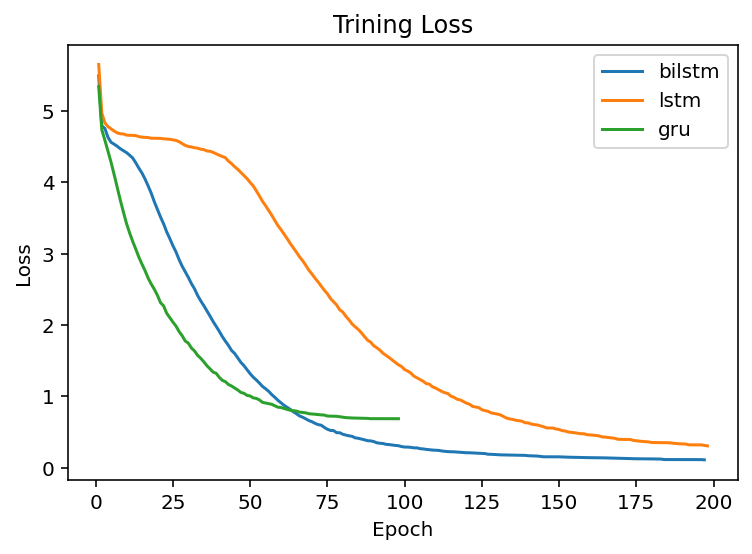

In [45]:
import matplotlib.pyplot as plt
plt.plot(epoch_bilstm,loss_bilstm,label="bilstm")
plt.plot(epoch_lstm,loss_lstm,label="lstm")
plt.plot(epoch_gru,loss_gru,label="gru")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Trining Loss")
plt.savefig('foo.png')

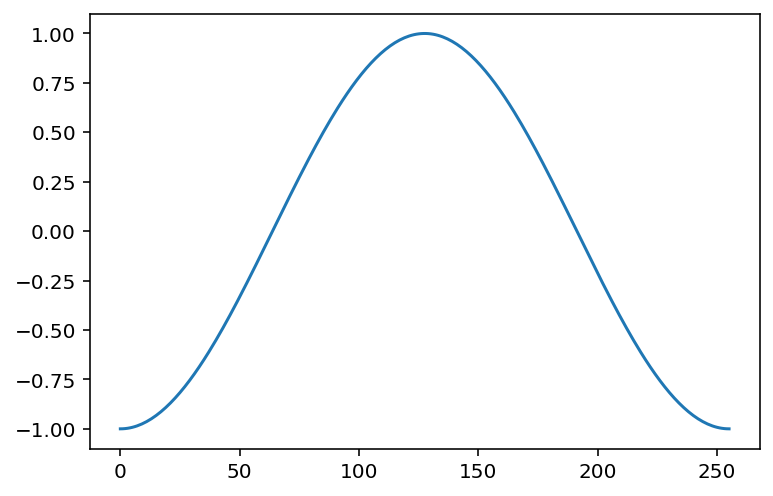

In [25]:
import numpy as np

X = np.linspace(-np.pi, np.pi, 256, endpoint=True)
C, S = np.cos(X), np.sin(X)
plt.plot(C)
plt.show()

In [27]:
C

array([-1.        , -0.99969645, -0.99878599, -0.99726917, -0.99514692,
       -0.99242051, -0.98909161, -0.98516223, -0.98063477, -0.97551197,
       -0.96979694, -0.96349314, -0.95660442, -0.94913494, -0.94108925,
       -0.93247223, -0.92328911, -0.91354546, -0.9032472 , -0.89240058,
       -0.88101219, -0.86908895, -0.85663808, -0.84366715, -0.83018403,
       -0.81619691, -0.80171428, -0.78674494, -0.77129796, -0.75538273,
       -0.73900892, -0.72218645, -0.70492555, -0.68723669, -0.66913061,
       -0.6506183 , -0.63171101, -0.6124202 , -0.5927576 , -0.57273514,
       -0.55236497, -0.53165947, -0.51063119, -0.48929292, -0.46765759,
       -0.44573836, -0.42354851, -0.40110153, -0.37841105, -0.35549083,
       -0.3323548 , -0.30901699, -0.28549159, -0.26179286, -0.2379352 ,
       -0.21393308, -0.18980109, -0.16555388, -0.14120615, -0.1167727 ,
       -0.09226836, -0.067708  , -0.04310654, -0.0184789 ,  0.00615995,
        0.03079506,  0.05541147,  0.07999425,  0.10452846,  0.12